In [20]:
from pathlib import Path
import sys
from torchvision import transforms
from torch.nn.functional import one_hot


sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent / "label_anything"))
sys.path.append(str(Path.cwd().parent / "label_anything" / "data"))

import os
from label_anything.data.test import LabelAnythingTestDataset
from label_anything.data.utils import BatchKeys
from torchvision.transforms import ToTensor
from PIL import Image
import json
import random
import torch
from pycocotools import mask as mask_utils

In [22]:
class BrainMriTestDataset(LabelAnythingTestDataset):
    num_classes = 2

    def __init__(
        self,
        annotations: str,
        img_dir: str,
        preprocess=None,
    ):
        super().__init__()
        with open(annotations, "r") as f:
            annotations = json.load(f)
        self.annotations = annotations
        self.img_dir = img_dir  # data/raw/lgg-mri-segmentation/kaggle_3m/
        self.preprocess = preprocess
        self.image_to_category = self._image_to_category()

    def _image_to_category(self):
        image_to_category = {}
        for annotation in self.annotations["annotations"]:
            image_id = annotation["image_id"]
            category_id = annotation["category_id"]
            image_to_category[image_id] = category_id
        return image_to_category

    def __len__(self):
        return len(self.annotations["images"])

    def extract_prompts(self):
        cat_images = [
            img for img, cat_id in self.image_to_category.items() if cat_id == 1
        ]
        selected_images = random.sample(cat_images, min(5, len(cat_images)))

        # Get image data
        image_data = [self._get_image_by_id(image_id) for image_id in selected_images]
        images, sizes = zip(*image_data)
        images = torch.stack(images)
        sizes = torch.stack(sizes)

        # Get ground truth data
        masks = [self._get_gt_by_id(image_id) for image_id in selected_images]
        masks = torch.stack(masks)

        # Create flag masks
        flag_masks = torch.tensor(
            [1 if torch.sum(mask).item() > 0 else 0 for mask in masks]
        )
        masks = one_hot(masks.long(), 2).permute(0, 3, 1, 2).float()


        return {
            BatchKeys.IMAGES: images,
            BatchKeys.PROMPT_MASKS: masks,
            BatchKeys.FLAG_MASKS: flag_masks,
            BatchKeys.DIMS: sizes,
        }

    def _get_image_by_id(self, image_id):
        for image in self.annotations["images"]:
            if image["id"] == image_id:
                return self._get_image(image)

    def _get_gt_by_id(self, image_id):
        for annotation in self.annotations["annotations"]:
            if annotation["image_id"] == image_id:
                return self._get_gt(annotation)

    def _get_image(self, image_info):
        image_path = os.path.join(self.img_dir, image_info["url"])
        img = Image.open(image_path)
        size = img.size
        if self.preprocess:
            img = self.preprocess(img)  # 3 x h x w
        return img, torch.tensor(size)

    def _get_gt(self, annotation_info):
        mask = mask_utils.decode(annotation_info["segmentation"])
        if self.preprocess:
            mask = torch.from_numpy(mask)
        return mask

    def __getitem__(self, idx):
        image_info = self.annotations["images"][idx]
        annotation_info = self.annotations["annotations"][idx]
        image, _ = self._get_image(image_info)
        size = torch.tensor(image.shape[1:]).unsqueeze(0)  # Example dimension
        gt = self._get_gt(annotation_info)
        return {
            BatchKeys.IMAGES: image,
            BatchKeys.DIMS: size,
        }, gt  # {BatchKeys.GROUND_TRUTHS: gt}

In [16]:
annotations = "/home/emanuele/LabelAnything/data/annotations/brain_mri.json"
img_dir = "/home/emanuele/LabelAnything/data/raw/lgg-mri-segmentation/kaggle_3m/"

In [23]:
from label_anything.data.transforms import CustomNormalize, CustomResize

preprocess = transforms.Compose(
    [
        CustomResize(1024),
        transforms.PILToTensor(),
        CustomNormalize(),
    ]
)
dataset = BrainMriTestDataset(annotations, img_dir, preprocess=preprocess)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)

In [24]:
prompts = dataloader.dataset.extract_prompts()

In [25]:
for k, v in prompts.items():
    print(f'{k}: {v.size()}')

images: torch.Size([5, 3, 1024, 1024])
prompt_masks: torch.Size([5, 2, 256, 256])
flag_masks: torch.Size([5])
dims: torch.Size([5, 2])


In [27]:
prompt_masks = prompts[BatchKeys.PROMPT_MASKS]
prompt_masks.size()

torch.Size([5, 2, 256, 256])

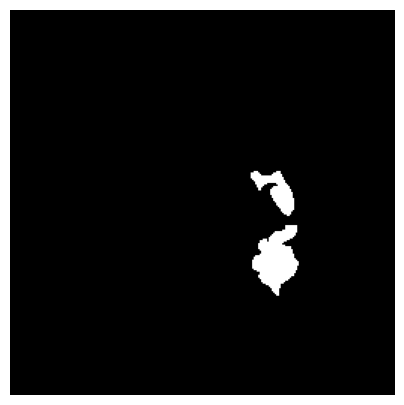

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pycocotools import mask as mask_util


def plot_mask(segmentation, figsize=(5, 5)):
    # Decodifica la maschera usando pycocotools
    mask = mask_util.decode(segmentation)

    # Crea una figura e un asse
    fig, ax = plt.subplots(figsize=figsize)

    # Mostra la maschera
    ax.imshow(mask, cmap="gray")
    ax.axis("off")

    # Mostra il grafico
    plt.show()


maschera = {
    "size": [256, 256],
    "counts": "\\SX14l71iI1Z41cK2\\40aK1_41_K0a41UKHQO7NGi59VKLQO:i5GXKd0f4[OZKg0e4XO\\Kh0d4XO\\Ki0c4VO`Kh0`4XO]Kl0b4TO^JOg0o0i4SO_J1e0o0i4QOaJ3c0n0k4oNbJ4a0o0k4oNcJ4`0n0l4]OSKc0m4^ORK=U5CiJ:\\5EbJAFa0j5M_JAHa0l5LYJFL<m5NVJEN=m5MUJFN<P6KSJHN<R6HRJLN9U6FnI017c6HaI3a6KbI2X7Llj?",
}
plot_mask(maschera)

In [14]:
mask = mask_util.decode(maschera)
np.unique(mask)

array([0, 1], dtype=uint8)

In [6]:
data_dict, gt = next(iter(dataloader))

print(
    [
        f"{k}: {v.size() if isinstance(v, torch.Tensor) else v}"
        for k, v in data_dict.items()
    ]
)
# print([f"{k}: {v.size() if isinstance(v, torch.Tensor) else v}" for k, v in gt.items()])
print(f'masks: {gt.size()}')

['images: torch.Size([2, 3, 1024, 1024])', 'dims: torch.Size([2, 1, 2])']
masks: torch.Size([2, 3, 1024, 1024])


In [8]:
import matplotlib.pyplot as plt
import torch

[2024-02-09 16:34:05] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2024-02-09 16:34:05] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


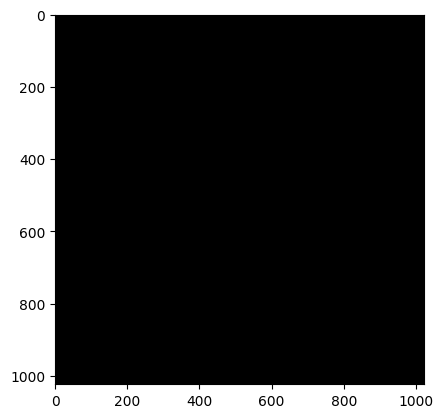

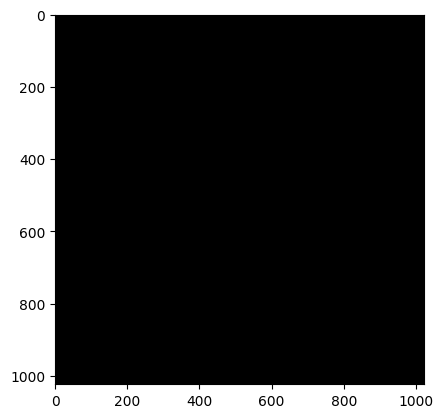

In [9]:
images = gt.permute(0, 2, 3, 1).numpy()

# Plot each image
for i, image in enumerate(images):
    plt.figure(i)
    plt.imshow(image)

plt.show()

In [5]:
with open(annotations, "r") as f:
    annotations_file = json.load(f)

In [19]:
from pycocotools import mask as mask_utils

i = mask_utils.decode(seg)
# convert bbox to tensor
bbox = torch.tensor(bbox)

In [10]:
def image_to_category(annotations):
    image_to_category = {}
    for annotation in annotations["annotations"]:
        image_id = annotation["image_id"]
        category_id = annotation["category_id"]
        image_to_category[image_id] = category_id
    return image_to_category

In [11]:
a = image_to_category(annotations_file)

In [ ]:
a